In [ ]:
!pip install torchsummary

In [1]:
import torch
from skimage.io import imread
from torch.utils import data
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from dataloader import DataLoader
from losses import bce_loss, dice_loss, focal_loss
from network import EncDec, UNet

import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\danie\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


cpu


In [2]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])


trainset = DataLoader(data_path="data", transform=train_transform, train=True)

testset = DataLoader(data_path="data", transform=test_transform)

# dataloader training
train_loader = data.DataLoader(dataset=trainset,
                                 batch_size=2,
                                 shuffle=True)
# dataloader validation
test_loader = data.DataLoader(dataset=testset,
                                   batch_size=2,
                                   shuffle=True)

x, y = next(iter(train_loader))

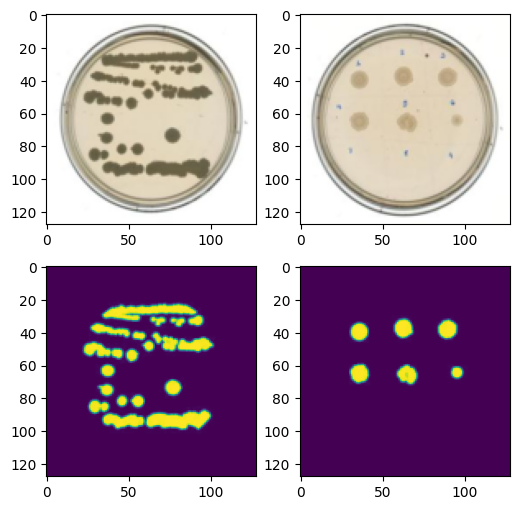

In [3]:
plt.rcParams['figure.figsize'] = [6, 6]

images, labels = next(iter(train_loader))

for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 2, i+3)
    plt.imshow(labels[i].squeeze())
plt.show()

In [4]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))

Loaded 160 training images
Loaded 40 test images


In [5]:
def iou(target, prediction):
    intersection = torch.sum(torch.logical_and(target, prediction))
    union = torch.sum(torch.logical_or(target, prediction))
    return (intersection.item()/union.item())

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + TN +FN)

def sensitivity(TP, FN):
    return TP / (TP + FN)

def specificity(TN, FP):
    return TN / (FP + TN) 

def dice(target, prediction):
    return 2 * torch.sum(torch.logical_and(target, prediction)) / (target.sum() + prediction.sum())

def compute_confusion(target, prediction):
    TP = torch.sum(torch.logical_and(prediction == 1, target == 1))
    TN = torch.sum(torch.logical_and(prediction == 0, target == 0))
    FP = torch.sum(torch.logical_and(prediction == 1, target == 0))
    FN = torch.sum(torch.logical_and(prediction == 0, target == 1))
                
    return TP.item(), TN.item(), FP.item(), FN.item()

In [6]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))
    out_dict = {'train_acc': [],
              'validation_acc': [],
              'train_loss': [],
              'validation_loss': []}

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        metrics = {
                    'iou': 0,
                    'accuracy': 0,
                    'sensitivity': 0,
                    'specificity': 0,
                    'dice': 0
                    }
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
            prediction = torch.where(F.sigmoid(Y_pred) > 0.5, 1, 0).detach().cpu()
            target = Y_batch.detach().cpu()
            
            TP, TN, FP, FN = compute_confusion(target, prediction)
            metrics['iou'] += iou(target, prediction) / len(train_loader)
            metrics['accuracy'] += accuracy(TP, TN, FP, FN) / len(train_loader)
            metrics['sensitivity'] += sensitivity(TP, FN) / len(train_loader)
            metrics['specificity'] += specificity(TN, FP) / len(train_loader)
            metrics['dice'] += dice(target, prediction) / len(train_loader)
            
        toc = time()
        out_dict["train_loss"].append(avg_loss.item())
        print(' - Train loss: %f' % avg_loss)
        
        

        avg_loss = 0
        metrics = {
                    'iou': 0,
                    'accuracy': 0,
                    'sensitivity': 0,
                    'specificity': 0,
                    'dice': 0
                    }
        model.eval()  # testing mode
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(test_loader)
            prediction = torch.where(F.sigmoid(Y_pred) > 0.5, 1, 0).detach().cpu()
            target = Y_batch.detach().cpu()
            
            TP, TN, FP, FN = compute_confusion(target, prediction)
            metrics['iou'] += iou(target, prediction) / len(test_loader)
            metrics['accuracy'] += accuracy(TP, TN, FP, FN) / len(test_loader)
            metrics['sensitivity'] += sensitivity(TP, FN) / len(test_loader)
            metrics['specificity'] += specificity(TN, FP) / len(test_loader)
            metrics['dice'] += dice(target, prediction) / len(test_loader)
            
        toc = time()
        out_dict["validation_loss"].append(avg_loss.item())
        print(' - Validation loss: %f' % avg_loss)
        print(f"IOU is {metrics['iou']}, accuracy is {metrics['accuracy']}, sensitivity is {metrics['sensitivity']}, specificity is {metrics['specificity']}, dice is {metrics['dice']}")
        
        
        
        # show intermediate results
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        print(f"IOU is {metrics['iou']}, accuracy is {metrics['accuracy']}, sensitivity is {metrics['sensitivity']}, specificity is {metrics['specificity']}, dice is {metrics['dice']}")
        
        
    return out_dict

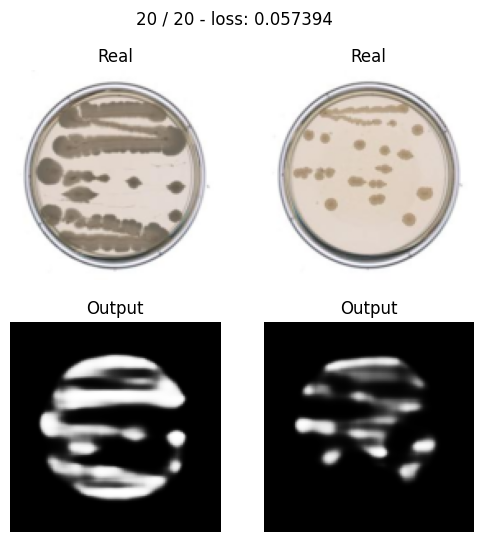

IOU is 0.513825688744686, accuracy is 0.9996690922733037, sensitivity is 0.996187750433569, specificity is 0.9997813117386024, dice is 0.9884273409843445


In [8]:
model = EncDec().to(device)
# summary(model, (3, 256, 256))
out_dict = train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

In [9]:
#def predict(model, data):
#    model.eval()  # testing mode
#    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
#    return np.array(Y_pred)

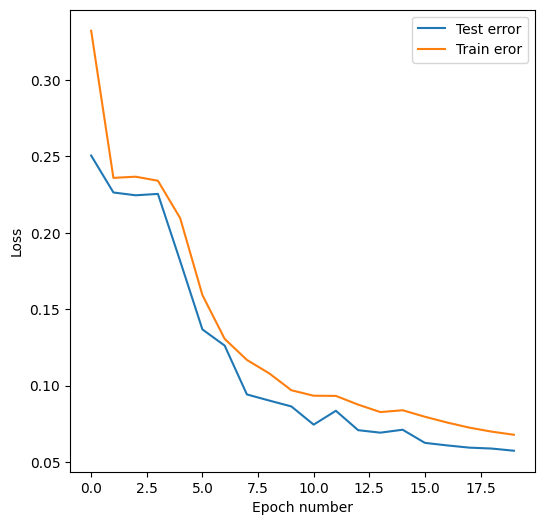

In [10]:
plt.plot(range(len(out_dict["validation_loss"])), out_dict["validation_loss"])
plt.plot(range(len(out_dict["train_loss"])), out_dict["train_loss"])
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

In [11]:
def bce_loss(y_real, y_pred):
    y_pred = torch.clip(y_pred, min=-10, max=10)
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [12]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return 1 - (torch.mean(2*y_pred*y_real + 1) / (torch.mean(y_pred + y_real) + 1))

In [13]:
def focal_loss(y_real, y_pred):
    y_pred_s = torch.sigmoid(y_pred)
    return -torch.sum((((1-y_pred_s)**2) * y_real * torch.log(y_pred_s)) + ((1 - y_real) * torch.log(1-y_pred_s)))

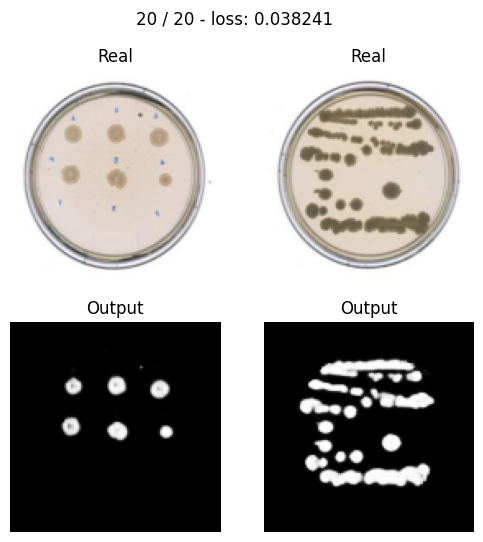

IOU is 0.522717940484258, accuracy is 0.999706531786399, sensitivity is 0.9962202534367584, specificity is 0.9998440140018633, dice is 1.002427339553833


In [16]:
model = UNet().to(device)
out_dict = train(model, optim.Adam(model.parameters(), lr=1e-3), bce_loss, 20, train_loader, test_loader)

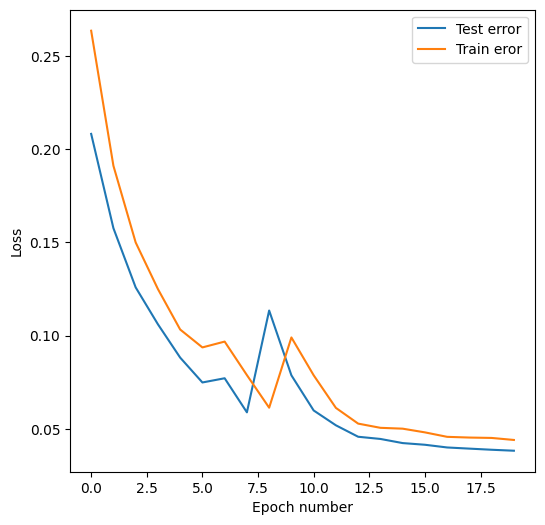

In [17]:
plt.plot(range(len(out_dict["validation_loss"])), out_dict["validation_loss"])
plt.plot(range(len(out_dict["train_loss"])), out_dict["train_loss"])
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

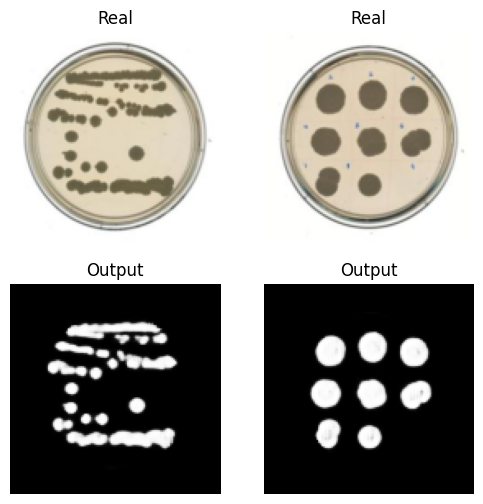

In [18]:
# show intermediate results
X_train, Y_train = next(iter(train_loader))
Y_hat = F.sigmoid(model(X_train.to(device))).detach().cpu()
clear_output(wait=True)
for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_train[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
# plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
plt.show()

In [169]:
def predict(model, data):
    model.eval()  
    Y_pred = [F.sigmoid(model(X.to(device))) for X, _ in data]
    return Y_pred

In [182]:
Y_pred = predict(model, test_loader)

In [183]:
Y_pred_f = []

for i in range(len(Y_pred)):
    a = np.squeeze(Y_pred[i][0].detach().numpy())
    b = np.squeeze(Y_pred[i][1].detach().numpy())
    Y_pred_f.append(a)
    Y_pred_f.append(b)

In [179]:
Y_true = [Y.to(device) for _, Y in test_loader]

In [180]:
Y_true_f = []

for i in range(len(Y_true)):
    a = np.squeeze(Y_true[i][0].detach().numpy())
    b = np.squeeze(Y_true[i][1].detach().numpy())
    Y_true_f.append(a)
    Y_true_f.append(b)

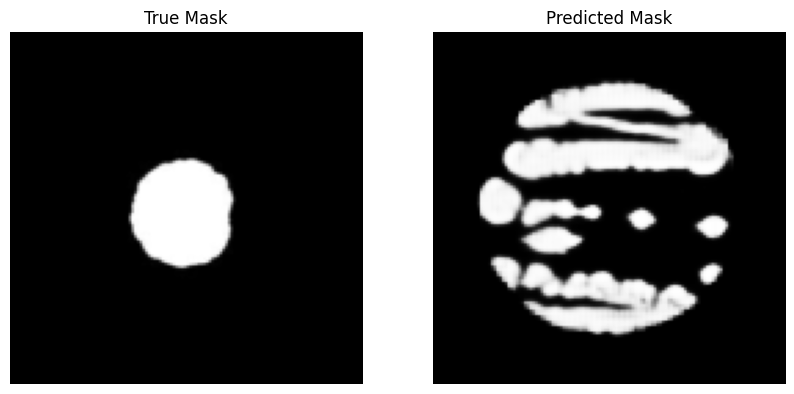

In [184]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(Y_true_f[0], cmap='gray')
axs[0].set_title('True Mask')
axs[0].axis('off')

axs[1].imshow(Y_pred_f[0], cmap='gray')
axs[1].set_title('Predicted Mask')
axs[1].axis('off')

plt.show()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 